In [2]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) )
X_valid = X_valid.reshape( (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1) )
X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) )
y_train = y_train.reshape( (-1, 1) )
y_valid = y_valid.reshape( (-1, 1) )
y_test = y_test.reshape( (-1, 1) )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(161825, 120, 25, 1) (161825, 1)
(5000, 120, 25, 1) (5000, 1)
(10000, 120, 25, 1) (10000, 1)


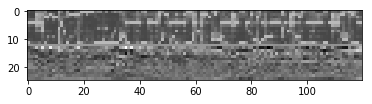

In [4]:
plt.imshow(X_train[2, :, :, 0].T, cmap='gray')

In [5]:
med = np.median(y_train)

def accuracy(pred, labels):
    return ( (pred > med) == (labels > med) ).mean()*100

In [10]:
batch_size = 64
time = 120
num_chromas = 12

pitch_convs = [
    [1, 12, 1, 32],
    [1, 1, 32, 64],
    [11, 1, 64, 128],
    [5, 1, 128, 128],
    [5, 1, 128, 64]
]
timbre_convs = pitch_convs
loudness_convs = [
    [11, 1, 1, 128],
    [5, 1, 128, 128],
    [5, 1, 128, 64]
]

overall_size = 0

size = time, num_chromas
for s in pitch_convs:
    size = size[0] - s[0] + 1, size[1] - s[1] + 1
overall_size += size[0]*size[1]*pitch_convs[-1][3]

size = time, num_chromas
for s in timbre_convs:
    size = size[0] - s[0] + 1, size[1] - s[1] + 1
overall_size += size[0]*size[1]*timbre_convs[-1][3]

size = time, 1
for s in loudness_convs:
    size = size[0] - s[0] + 1, size[1] - s[1] + 1
overall_size += size[0]*size[1]*loudness_convs[-1][3]
    
dense = [
    [overall_size, 128],
    [128, 32],
    [32, 16],
    [16, 1]
]
dense_dropout = [1.0, 1.0, 1.0, 1.0]

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_pitch = tf.placeholder(
    tf.float32, shape=(batch_size, time, num_chromas, 1))
  tf_train_timbre = tf.placeholder(
    tf.float32, shape=(batch_size, time, num_chromas, 1))
  tf_train_loudness = tf.placeholder(
    tf.float32, shape=(batch_size, time, 1, 1))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))

  tf_valid_pitch = tf.constant(np.float32(X_valid[:, :, :12]))
  tf_valid_timbre = tf.constant(np.float32(X_valid[:, :, 12:24]))
  tf_valid_loudness = tf.constant(np.float32(X_valid[:, :, 24:25]))
    
  tf_test_pitch = tf.constant(np.float32(X_test[:5000, :, :12]))
  tf_test_timbre = tf.constant(np.float32(X_test[:5000, :, 12:24]))
  tf_test_loudness = tf.constant(np.float32(X_test[:5000, :, 24:25]))

  # Variables.
  w_pitch = []
  b_pitch = []
  w_timbre = []
  b_timbre = []
  w_loudness = []
  b_loudness = []
  for s in pitch_convs:
    w_pitch.append(tf.Variable(tf.truncated_normal(s, stddev=0.1)))
    b_pitch.append(tf.Variable(tf.zeros([s[3]])))
  for s in timbre_convs:
    w_timbre.append(tf.Variable(tf.truncated_normal(s, stddev=0.1)))
    b_timbre.append(tf.Variable(tf.zeros([s[3]])))
  for s in loudness_convs:
    w_loudness.append(tf.Variable(tf.truncated_normal(s, stddev=0.1)))
    b_loudness.append(tf.Variable(tf.zeros([s[3]])))

  w_dense=[]
  b_dense=[]
  for s in dense:
    w_dense.append(tf.Variable(tf.truncated_normal(s, stddev=0.1)))
    b_dense.append(tf.Variable(tf.zeros(s[1])))
  
  # Model.
  def model(data_pitch, data_timbre, data_loudness):
    h_pitch = data_pitch
    for i in range(len(w_pitch)):
        h_pitch = tf.nn.conv2d(h_pitch, w_pitch[i], [1, 1, 1, 1], padding='VALID')
        h_pitch = tf.nn.relu(h_pitch + b_pitch[i])
    shape = h_pitch.get_shape().as_list()
    r_pitch = tf.reshape(h_pitch, [shape[0], shape[1] * shape[2] * shape[3]])
    
    h_timbre = data_timbre
    for i in range(len(w_timbre)):
        h_timbre = tf.nn.conv2d(h_timbre, w_timbre[i], [1, 1, 1, 1], padding='VALID')
        h_timbre = tf.nn.relu(h_timbre + b_timbre[i])
    shape = h_timbre.get_shape().as_list()
    r_timbre = tf.reshape(h_timbre, [shape[0], shape[1] * shape[2] * shape[3]])
        
    h_loudness = data_loudness
    for i in range(len(w_loudness)):
        h_loudness = tf.nn.conv2d(h_loudness, w_loudness[i], [1, 1, 1, 1], padding='VALID')
        h_loudness = tf.nn.relu(h_loudness + b_loudness[i])
    shape = h_loudness.get_shape().as_list()
    r_loudness = tf.reshape(h_loudness, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.concat([r_pitch, r_timbre, r_loudness], axis=1)
    #print( hidden.get_shape() , w_dense[0].get_shape())
    for i in range(len(w_dense)):
        hidden = tf.nn.xw_plus_b(hidden, w_dense[i], b_dense[i])
        if i < len(w_dense)-1:
            hidden = tf.nn.relu(hidden)
            #hidden = tf.nn.dropout(hidden, dense_dropout[i])
    
    return hidden
  
  # Training computation.
  logits = model(tf_train_pitch, tf_train_timbre, tf_train_loudness)
  loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(1e-3).minimize(loss)
  optimizer = tf.train.AdamOptimizer(2e-4).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.sigmoid(logits)
  valid_prediction = tf.nn.sigmoid(model(tf_valid_pitch, tf_valid_timbre, tf_valid_loudness))
  test_prediction = tf.nn.sigmoid(model(tf_test_pitch, tf_test_timbre, tf_test_loudness))

Initialized
Avg loss at step 0: 0.701834
Minibatch accuracy: 60.9%
Validation accuracy: 49.2%
Avg loss at step 100: 0.650929
Minibatch accuracy: 53.1%
Validation accuracy: 56.9%
Avg loss at step 200: 0.645346
Minibatch accuracy: 57.8%
Validation accuracy: 57.2%
Avg loss at step 300: 0.644004
Minibatch accuracy: 54.7%
Validation accuracy: 56.1%
Avg loss at step 400: 0.646996
Minibatch accuracy: 54.7%
Validation accuracy: 58.1%
Avg loss at step 500: 0.646931
Minibatch accuracy: 57.8%
Validation accuracy: 57.8%
Avg loss at step 600: 0.643137
Minibatch accuracy: 51.6%
Validation accuracy: 57.8%
Avg loss at step 700: 0.645058
Minibatch accuracy: 67.2%
Validation accuracy: 58.3%
Avg loss at step 800: 0.647098
Minibatch accuracy: 56.2%
Validation accuracy: 57.5%
Avg loss at step 900: 0.646026
Minibatch accuracy: 54.7%
Validation accuracy: 56.5%
Avg loss at step 1000: 0.643841
Minibatch accuracy: 67.2%
Validation accuracy: 57.4%
Avg loss at step 1100: 0.647658
Minibatch accuracy: 51.6%
Validat

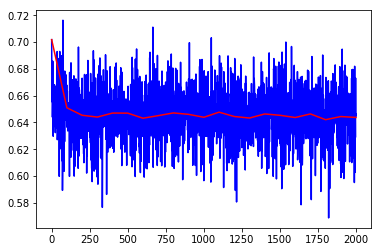

In [12]:
num_steps = 2001

with tf.Session(graph=graph) as session:
  losses=[]
  avg=[]
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {tf_train_pitch : batch_data[:, :, :12], tf_train_timbre : batch_data[:, :, 12:24], tf_train_loudness : batch_data[:, :, 24:25], tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    losses.append(l)
    if (step % 100 == 0):
      avg.append(sum(losses[-100:])/len(losses[-100:]))
      print('Avg loss at step %d: %f' % (step, avg[-1]))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), y_test[:5000]))
  plt.plot(range(num_steps), losses, 'b', np.array(range(len(avg)))*100, avg, 'r')
  plt.show()